##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train and serve a TensorFlow model with TensorFlow Serving


**Warning: This notebook is designed to be run in a Google Colab only**.  It installs packages on the system and requires root access.  If you want to run it in a local Jupyter notebook, please proceed with caution.

Note: You can run this example right now in a Jupyter-style notebook, no setup required!  Just click "Run in Google Colab"

<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<tr><td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/serving/rest_simple">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
<td><a href="https://storage.googleapis.com/tensorflow_docs/tfx/docs/tutorials/serving/rest_simple.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td>
</tr></table></div>

This guide trains a neural network model to classify [images of clothing, like sneakers and shirts](https://github.com/zalandoresearch/fashion-mnist), saves the trained model, and then serves it with [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).  The focus is on TensorFlow Serving, rather than the modeling and training in TensorFlow, so for a complete example which focuses on the modeling and training see the [Basic Classification example](https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/basic_classification.ipynb).

This guide uses [tf.keras](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/keras.ipynb), a high-level API to build and train models in TensorFlow.

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('MyDrive')

Mounted at MyDrive


In [ ]:
!ls -al ./

In [ ]:
import sys
import platform
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import subprocess

import tempfile
import json
import requests

python 3.7.2 \
3 : major
7 : minor
2 : micro

In [ ]:
# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [ ]:
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

print("SUDO_IF_NEEDED=", SUDO_IF_NEEDED)

SUDO_IF_NEEDED= 


In [ ]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install grpcio

Installing dependencies for Colab environment
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# docs_infra: no_execute
!pip install -q requests

In [ ]:
!apt-get install net-tools

In [ ]:
platform.platform()

'Linux-5.10.133+-x86_64-with-glibc2.27'

In [ ]:
!ldd --version

In [ ]:
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.9.2


In [ ]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone https://github.com/tensorflow/models

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd /content/models/research/
protoc object_detection/protos/*.proto --python_out=.
cd /content
git clone https://github.com/cocodataset/cocoapi.git
cd /content/cocoapi/PythonAPI
make
cp -r pycocotools /content/models/research/
cd /content/models/research/
cp object_detection/packages/tf2/setup.py .
python -m pip install .
cd /content

In [ ]:
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

In [ ]:
!pwd

/content


In [ ]:
# !tar -xzvf "/content/MyDrive/MyDrive/Tensorflow_OD_API/tensorflow serving model/efficientdet_d1_coco17_tpu-32.tar.gz"

mkdir -p option : 만약 부모 디렉토리가 존재하지 않는다면, 부모 디렉토리까지 생성

In [ ]:
!mkdir -p obj_detection/1

In [ ]:
# !cp "/content/efficientdet_d1_coco17_tpu-32/saved_model/saved_model.pb" \
# /content/obj_detection/1

In [ ]:
!cp "/content/MyDrive/MyDrive/Tensorflow_OD_API/ssd_mobilenet_v2/saved_model.pb" \
/content/obj_detection/1

In [ ]:
!cp -r "/content/MyDrive/MyDrive/Tensorflow_OD_API/ssd_mobilenet_v2/variables" \
/content/obj_detection/1

In [ ]:
!pwd

/content


In [ ]:
export_path = "/content/obj_detection/1"

In [ ]:
!saved_model_cli show --dir {export_path} --all

In [ ]:
MODEL_DIR = "/content/obj_detection"
print("MODEL_DIR=", MODEL_DIR)

MODEL_DIR= /content/obj_detection


In [ ]:
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
print("export_path=", export_path)

export_path = /content/obj_detection/1

export_path= /content/obj_detection/1


In [ ]:
!ls -la {export_path}

total 8684
drwxr-xr-x 3 root root    4096 Dec 23 00:09 .
drwxr-xr-x 3 root root    4096 Dec 23 00:09 ..
-rw------- 1 root root 8876207 Dec 23 00:09 saved_model.pb
drwx------ 2 root root    4096 Dec 23 00:09 variables


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](../signature_defs) (the methods you can call) in our SavedModel.  See [this discussion of the SavedModel CLI](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel) in the TensorFlow Guide.

In [ ]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

### Install TensorFlow Serving

This is all you need - one command line!

In [ ]:
# !{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

### Start running TensorFlow Serving

This is where we start running TensorFlow Serving and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [ ]:
print(MODEL_DIR)

/content/obj_detection


In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
MODEL="ssd_mobilenet_v2"

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=ssd_mobilenet_v2 \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


#### bg
해당 프로세스를 foreground가 아닌 background 작업으로 실행시키는 명령

#### nohup

리눅스, 유닉스에서 쉘스크립트파일 (*.sh)을 데몬형태로 실행시키는 프로그램

터미널 세션이 끊겨도 실행을 멈추지 않고 동작하도록 함

In [ ]:
!ps -A

In [ ]:
!netstat -tnlp

In [ ]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


## Make a request to your model in TensorFlow Serving

First, let's take a look at a random example from our test data.

Ok, that looks interesting.  How hard is that for you to recognize? Now let's create the JSON object for a batch of  three inference requests, and see how well our model recognizes things:

In [ ]:
import numpy as np
from PIL import Image

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [ ]:
!mkdir inferimages

In [ ]:
IMAGES_PATH="/content/inferimages"

In [ ]:
PROTOCOL = 'rest'

In [ ]:
SERVER_URL = 'http://localhost:8501/v1/models/{}:predict'.format(MODEL)
print(SERVER_URL)

http://localhost:8501/v1/models/ssd_mobilenet_v2:predict


In [ ]:
def get_random_image(image_dir):
    image_path = os.path.join(image_dir, random.choice(os.listdir(image_dir)))
    print("test image:", image_path)
    image = Image.open(image_path)
    (im_width, im_height) = image.size

    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [ ]:
# def get_random_image(image_dir):
#     image_path = os.path.join(image_dir, random.choice(os.listdir(image_dir)))
#     print("test image:", image_path)
#     image = Image.open(image_path)
#     (im_width, im_height) = image.size

#     return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [ ]:
def make_request(batch_size):   
    image_path = os.path.join(IMAGES_PATH, random.choice(os.listdir(IMAGES_PATH))) 
    np_images = np.repeat(np.expand_dims(get_random_image(IMAGES_PATH), 0).tolist(), batch_size, axis=0)
    print("*"*60)
    print(np_images.shape)
    return (image_path, np_images)

In [ ]:
# def make_request(batch_size):    
#     image_path, a = get_random_image(IMAGES_PATH)
 
#     print(image_path)
    
#     np_images = np.repeat(np.expand_dims(a.tolist(), batch_size, axis=0))
#     print("*"*60)
#     print(np_images.shape)
#     return image_path, np_images

In [ ]:
header = {"content-type": "application/json"}

In [ ]:
def send_request(predict_request):
    response = requests.post(SERVER_URL, data=predict_request, headers=header) 

    return response

In [ ]:
import time

In [ ]:
def benchmark(batch_size=1, num_iteration=20, warm_up_iteration=10):
    
    total_time = 0
    
    image_path, predict_request = make_request(batch_size)
    print("predict_request", type(predict_request))
    data = json.dumps({"signature_name": "serving_default", "instances": predict_request.tolist()})
    print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))
    start_time = time.time()
    
    response = send_request(data)     
    print(response)   
    
    predictions = json.loads(response.text)['predictions']
    
    
    return (image_path , predictions)
        # if i > warm_up_iteration:
        #     total_time += time_consume

    # time_average = total_time / (num_iteration - warm_up_iteration)
    # print('Average time: %.3f sec' % (time_average))
    # print('Batch size = %d' % batch_size)
    # if batch_size == 1:
    #     print('Latency: %.3f ms' % (time_average * 1000))
    # print('Throughput: %.3f images/sec' % (batch_size / time_average))

In [ ]:
current_target_image_path, predictions = benchmark(batch_size=1, num_iteration=1, warm_up_iteration=10)

test image: /content/inferimages/cake1.jpg
************************************************************
(1, 1080, 1080, 3)
predict_request <class 'numpy.ndarray'>
Data: {"signature_name": "serving_default", "instances": ... 226, 180, 146], [227, 181, 147], [229, 183, 149]]]]}
<Response [200]>


In [ ]:
print(current_target_image_path)

/content/inferimages/cake1.jpg


In [ ]:
image_np = load_image_into_numpy_array(current_target_image_path)

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
%matplotlib inline

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap("/content/MyDrive/MyDrive/Tensorflow_OD_API/ssd_mobilenet_v2/mscoco_label_map.pbtxt",use_display_name=True)

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [ ]:
def changetoInt(l, dtype=int):
    return list(map(dtype, l))

In [ ]:
detections = predictions[0]

num_detections = int(detections['num_detections'])
detections['num_detections'] = num_detections

detections['detection_boxes'] = np.array(detections['detection_boxes'])

detections['detection_classes'] = changetoInt(detections['detection_classes'])
detections['detection_classes'] = np.array(detections['detection_classes'])

detections['detection_scores'] = np.array(detections['detection_scores'])

Done


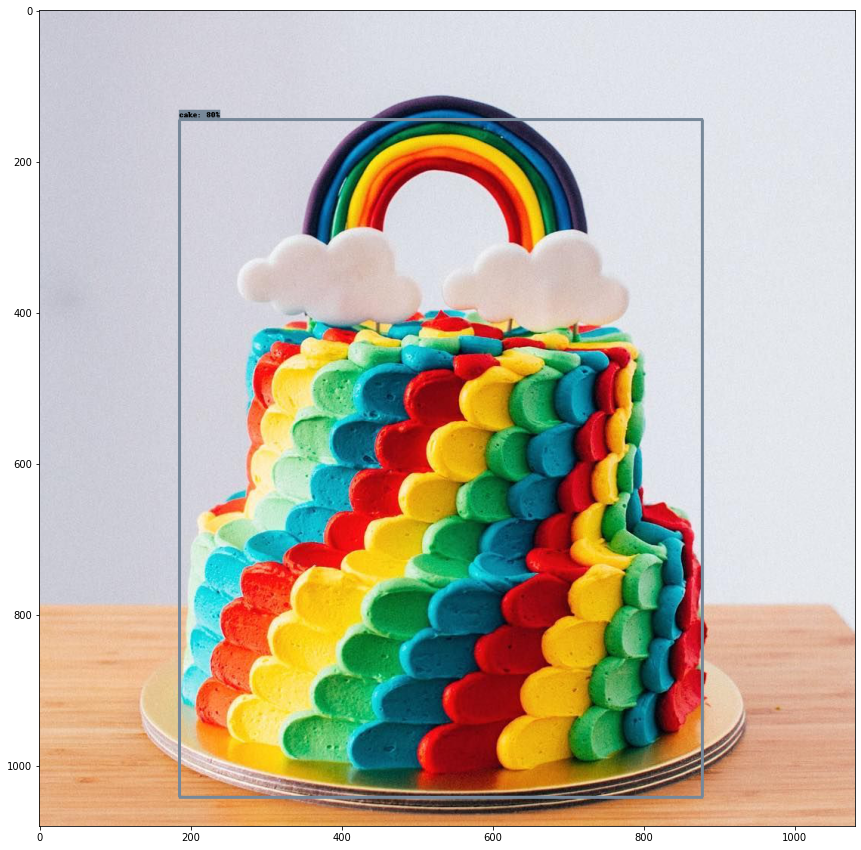

In [ ]:
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=.50,
      agnostic_mode=False)

plt.figure(figsize=(15,15))
plt.imshow(image_np_with_detections)
print('Done')
plt.show()

In [ ]:
!tail server.log

#### A particular version of the servable

Now let's specify a particular version of our servable.  Since we only have one, let's select version 1.  We'll also look at all three results.